# AdaBoost classifier

In this assignment, your task is to train an AdaBoost classifier on synthetic data. For reference, you are  provided with the posterior $P(y=1 \mid x)$, with $x$ regularly sampled over the domain $\mathcal{X} = [0,1]\times[0,1]$, so that you can see, in the end, how the output of the AdaBoost classifier better approximates the posterior at each round.

Please read the assignment entirely before you start coding, in order to get a sense of how it is organized. In particular, note that the AdaBoost algorithm is only run at the <a href='#AdaBoost-algorithm'>very last cell</a> of the 'Train the classifier' section. Before that, a number of functions are defined, one of which you need to complete.

 - <a href='#Train-the-classifier'>Question 1</a> (70%) Fill in the missing parts to implement the Adaboost algorithm described in class (slide 27 of the course). This involves iterating over the following steps:
  - <a href='#Finding-the-best-weak-learner'>a.</a> Find the best weak learner $h_t$ at each round.
  - <a href='#AdaBoost-algorithm'>b.</a> Using the weak learner's weighted error $\epsilon_t$, compute $\alpha_t$.
  - <a href='#AdaBoost-algorithm'>c.</a> Update the weight distribution $D_t$ of the training samples.
 - <a href='#Visualize-loss-function'>Question 2</a> (20%) Modify your loop to compute the loss $E_t = E(f(\mathbf{x}),\mathbf{y}) = \sum_{i=1}^{N} \exp(-y^i f(x^i))$ at each round. Then, plot $E_t$ and make sure that it is monotonically decreasing with time. Verify that $E_t$ provides an upper bound for the number of errors by plotting it on the same graph.
 - <a href='#Visualize-strong-learner-progress'>Question 3</a> (10%) First show the approximate posterior of your strong learner side-by-side with the original posterior. Then, show the approximate posteriors for each step at which the learner's response has been saved. Make sure that they look increasingly similar to the original posterior.
 
A word on notation:
 - The *response* of a weak learner $h$ for the sample $x$ is $-1$ or $+1$.
 - At each round we find the best weak learner, $h_t$, and define $f_t = \alpha_t h_t$. The *overall response* of the strong learner at round $t$ for the sample $x$, then, is $f(x) = \sum_t f_t(x) \in \mathbb{R}$ (note that we have a real number this time).  
 - $H(x) = \text{sign}(f(x)) \in \{-1,1\}$ is the *final classifier*.

# Code

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from construct_data import construct_data
%matplotlib inline

## Visualize training data and posterior

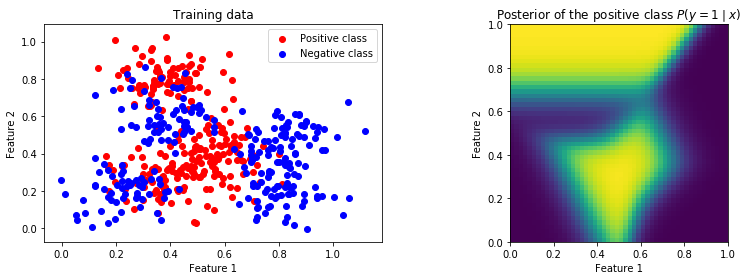

In [2]:
features, labels, posterior = construct_data(500, 'train', 'nonlinear', plusminus=True)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")

ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()

<a id='train-the-classifier'></a>

## Train the classifier

### Weak learner evaluation

The weak learner we use for this classification problem is a *decision stump* (cf. slide 26 of the course), whose response is defined as $h(x;s,\theta,d) =  s (2[x_{d}\geq\theta] - 1)$, where 
 - $d$ is the the dimension along which the decision is taken, 
 - $[\cdot]$ is 1 if $\cdot$ is true and 0 otherwise, 
 - $\theta$ is the threshold applied along dimension $d$ and 
 - $s\in\{-1,1\}$ is the polarity of the decision stump (this is a multiplicative factor, not a function!).

For example, if $s = 1$, the decision stump will consider that all samples whose $d$-th feature is greater than $\theta$ are in the positive class $[h(x;s,\theta,d)=+1]$, and all samples with a feature strictly lower than $\theta$ are in the negative class $[h(x;s,\theta,d)=-1]$.

In [3]:
def evaluate_stump(features, polarity_wl, theta_wl, coordinate_wl):
    """Evaluate the stump's response for each point."""
    feature_slice = features[:, coordinate_wl]
    weak_learner_output = polarity_wl * (2*(feature_slice >= theta_wl) - 1)

    return weak_learner_output


def evaluate_stump_on_grid(x_rng, y_rng, polarity_wl, theta_wl, coordinate_wl):
    """Evaluate the stump's response for each point on a rectangular grid."""
    feature_slice = np.meshgrid(x_rng, y_rng)[coordinate_wl]
    weak_learner_on_grid = polarity_wl * (2*(feature_slice >= theta_wl) - 1)

    return weak_learner_on_grid

### Finding the best weak learner

At each round of AdaBoost, the samples are reweighted, thus producing a new classification problem, where the samples with a larger weigth count more in the classification error. The first step of a new round is to find the weak learner with the best performance for this new problem, that is, with the smallest classification error: 
$$
  \epsilon(s,\theta,d) = \sum_{i=1}^{N} D^i_t[y^i \neq h(x^i;s,\theta,d)]\\
  (s_t,\theta_t,d_t) = \arg\min\ \epsilon(s,\theta,d)\\
  \epsilon_t = \epsilon(s_t,\theta_t,d_t)\\
  h_t(x) = h(x;s_t,\theta_t,d_t)
$$

Notes on the implementation:
 - The error $\epsilon$ is normalized in the course's slides, but in practice you don't need to, since the weights $D^i$ are already normalized in the main loop of the algorithm.
 - When we try all the different $(s,\theta,d)$ combinations to find the best weak learner, we have $s\in\{-1,1\}$, $d\in\{0,1\}$ (because we have 2 features), and $\theta\in\{x^i_d\}$ (where $i$ indexes the training samples).
 - Note that `find_best_weak_learner` returns $s_t$, $\theta_t$, $d_t$ and $\epsilon_t$.

In [4]:
def find_best_weak_learner(weights, features, labels):
    """Find the best decision stump for the given weight distribution.
    
    Returns
    -------
    polarity_wl : {-1, 1}
      Polarity 's' of the decision stump.
    theta_wl : float
      Threshold 'theta' for the decision.
    coordinate_wl : int
      Dimension 'd' along which the threshold is applied.
    err_wl : float
      Weighted error for the decision stump.

    """
    # TODO (Question 1)
    s_array = np.array([-1,1])
    d_array = range(features.shape[1])
    err_wl = float('Inf')
    for s in s_array:
        for d in d_array:
            for theta in features[:,d]:
                e = 0
                weak_learner_output = evaluate_stump(features, s, theta, d)
                no_diff_el = (weak_learner_output!=labels)
                e = sum(no_diff_el*weights)
                if abs(e)<abs(err_wl):
                    err_wl = e
                    polarity_wl = s
                    theta_wl = theta
                    coordinate_wl = d
    # /TODO (Question 1)

    return polarity_wl, theta_wl, coordinate_wl, err_wl

### AdaBoost algorithm

In [5]:
npoints, nfeatures = features.shape
num_rounds_boosting = 400

# Initialize arrays.
weights = np.ones(npoints) / npoints  # Weight distribution on samples
f = np.zeros((num_rounds_boosting, npoints))  # Strong classifier response at each iteration
loss = np.zeros(num_rounds_boosting)  # AdaBoost loss function
num_errors = np.zeros(num_rounds_boosting)  # Number of errors at each round

f_on_grid = 0  # Used to plot function
x_rng = y_rng = np.linspace(0, 1, 50)

ft = np.zeros([1, npoints])
product = np.zeros([1, npoints])
for i in range(num_rounds_boosting):
    ## TODO (Question 1)
    # Find best weak learner at current round of boosting.
    polarity_wl, theta_wl, coordinate_wl, err_wl = find_best_weak_learner(weights,features,labels)
    # Estimate alpha.
    alpha = 0.5*np.log(np.true_divide(1-err_wl, err_wl))
    # Reweight samples.
    #Zt compute
    weak_learner_output = evaluate_stump(features, polarity_wl, theta_wl, coordinate_wl)
    Zt = sum(weights*np.exp(-alpha*labels*weak_learner_output))
    weights = np.true_divide(weights*np.exp(-alpha*labels*weak_learner_output), Zt)
    ## /TODO (Question 1)

    ## TODO (Question 2)
    # Compute overall response at current round.
    ft += alpha*weak_learner_output
    f[i,:]=ft
    # Compute loss at current round.
    loss[i] = sum(np.exp(-labels*f[i,:]))
    # Keep track of the number of errors given by the final classifier.
    product += alpha*weak_learner_output
    diff = 0
    for j in range(len(weak_learner_output)):
        H = np.sign(product[0,j])
        if H != labels[j]:
            diff += 1
    
    num_errors[i] = diff
    
    ## /TODO (Question 2)

    # Evaluate f on a grid to produce the images.
    weak_learner_on_grid = evaluate_stump_on_grid(x_rng, y_rng, polarity_wl, theta_wl, coordinate_wl)
    f_on_grid += alpha*weak_learner_on_grid
    # Save gridded f at specific iterations.
    if i == 10:
        f_10 = f_on_grid.copy()
    elif i == 50:
        f_50 = f_on_grid.copy()
    elif i == 100:
        f_100 = f_on_grid.copy()

## Visualize loss function

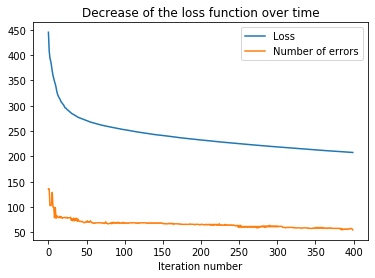

In [6]:
## TODO (Question 2)
fig, ax = plt.subplots()
ax.set_title("Decrease of the loss function over time")
ax.set_xlabel("Iteration number")
ax.plot(range(num_rounds_boosting), loss, label="Loss")
ax.plot(range(num_rounds_boosting), num_errors, label="Number of errors")
ax.legend()
## /TODO (Question 2)

plt.show()

## Visualize strong learner progress

It can be shown (cf. slide 36 of the course\*) that the AdaBoost strong classifier's response converges to half the *posterior log-ratio*:

$$\sum_{t=1}^\infty f_t(x) = \frac{1}{2} \log \left( \frac{P(y=1 \mid x)}{P(y=-1 \mid x)} \right),$$

which leads to an interesting method to approximate the posterior using the strong learner's response:

$$P(y=1 \mid x) \approx \frac{1}{1+\exp(-2f(x))}.$$

Therefore, we can check how good the response gets in terms of approximating the posterior.

<small>\*NB: There is a typo in this slide, the $\frac{1}{2}$ is missing.</small>

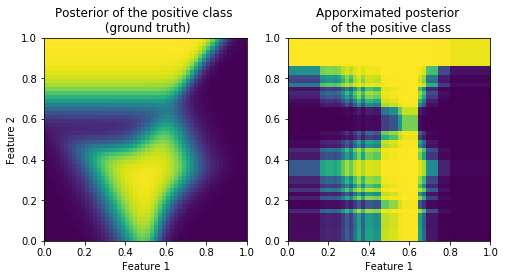

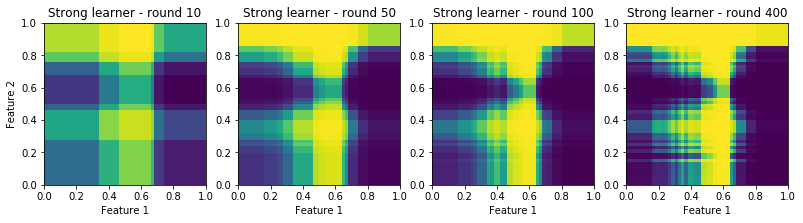

In [7]:
approx_posterior_10 = 1 / (1 + np.exp(-2 * f_10))
approx_posterior_50 = 1 / (1 + np.exp(-2 * f_50))
approx_posterior_100 = 1 / (1 + np.exp(-2 * f_100))
approx_posterior_400 = 1 / (1 + np.exp(-2 * f_on_grid))

# TODO (Question 3)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class \n (ground truth)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(approx_posterior_400, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Apporximated posterior \n of the positive class")
ax.set_xlabel("Feature 1")

fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(approx_posterior_10, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong learner - round 10")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 4, 2)
ax.imshow(approx_posterior_50, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong learner - round 50")
ax.set_xlabel("Feature 1")

ax = fig.add_subplot(1, 4, 3)
ax.imshow(approx_posterior_100, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong learner - round 100")
ax.set_xlabel("Feature 1")

ax = fig.add_subplot(1, 4, 4)
ax.imshow(approx_posterior_400, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong learner - round 400")
ax.set_xlabel("Feature 1")
# /TODO (Question 3)

plt.show()